Remove those patients that were classified as MCI at any point.

In [ ]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage.interpolation import zoom
from sklearn.model_selection import train_test_split

from utils import load_nifti

In [ ]:
output_shape = (96, 114, 96)
z_factor = 0.5
test_percentage = 0.2

# Prepare datasets

## 2 Year complete dataset

In [3]:
complete_annual_2yr_dir = "/analysis/share/ADNI/ADNI_tables/customized/ClassDxByImgClean_CompleteAnnual2YearVisitList_1_5T.csv"

In [4]:
df_2yr = pd.read_csv(complete_annual_2yr_dir)

In [5]:
df_2yr.head()

,RID,PTID,VISCODE,DX,EXAMDATE,Image.ID,Scan.Date,Sequence,Visit,Month_bl,...,Series.ID,DX_bl,DX_m12,DX_m24,DXdevelop,converter,label_three_fold,label_CN_AD,label_CN_MCI,label_MCI_AD
0,3,011_S_0003,bl,Dementia,2005-09-12,32237,9/1/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0.0000,...,9127,Dementia,Dementia,Dementia,Dementia-Dementia-Dementia,0,2,1.0,NaN,1.0
1,3,011_S_0003,m12,Dementia,2006-09-12,35576,9/12/06,MPR; GradWarp; B1 Correction; N3; Scaled,Month 12,11.9672,...,19096,Dementia,Dementia,Dementia,Dementia-Dementia-Dementia,0,2,1.0,NaN,1.0
2,3,011_S_0003,m24,Dementia,2007-09-12,88252,9/12/07,MPR; GradWarp; B1 Correction; N3; Scaled,Month 24,23.9344,...,39296,Dementia,Dementia,Dementia,Dementia-Dementia-Dementia,0,2,1.0,NaN,1.0
3,5,011_S_0005,bl,CN,2005-09-07,32246,9/2/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0.0000,...,9136,CN,CN,CN,CN-CN-CN,0,0,0.0,0.0,NaN
4,5,011_S_0005,m12,CN,2006-09-05,31906,9/5/06,MPR; GradWarp; B1 Correction; N3; Scaled,Month 12,11.9016,...,19041,CN,CN,CN,CN-CN-CN,0,0,0.0,0.0,NaN


In [6]:
print("Length with all subjects {}".format(len(df_2yr)))

Length with all subjects 1590


In [7]:
len(df_2yr["PTID"].drop_duplicates())

464

In [8]:
adni_small = pd.read_csv("/analysis/share/ADNI/ADNI_tables/customized/adniMergeSmall.csv")

In [9]:
adni_small.head()

,RID,PTID,VISCODE,DX,EXAMDATE,Month,M,Years_bl,Month_bl,COLPROT,...,FLDSTRENG,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX_bl,EXAMDATE_bl,FLDSTRENG_bl
0,2,011_S_0002,bl,CN,2005-09-08,0,0,0.000000,0.00000,ADNI1,...,1.5 Tesla MRI,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08,1.5 Tesla MRI
1,3,011_S_0003,bl,Dementia,2005-09-12,0,0,0.000000,0.00000,ADNI1,...,1.5 Tesla MRI,81.3,Male,18,Not Hisp/Latino,White,Married,AD,2005-09-12,1.5 Tesla MRI
2,3,011_S_0003,m06,Dementia,2006-03-13,6,6,0.498289,5.96721,ADNI1,...,1.5 Tesla MRI,81.3,Male,18,Not Hisp/Latino,White,Married,AD,2005-09-12,1.5 Tesla MRI
3,3,011_S_0003,m12,Dementia,2006-09-12,12,12,0.999316,11.96720,ADNI1,...,1.5 Tesla MRI,81.3,Male,18,Not Hisp/Latino,White,Married,AD,2005-09-12,1.5 Tesla MRI
4,3,011_S_0003,m24,Dementia,2007-09-12,24,24,1.998630,23.93440,ADNI1,...,1.5 Tesla MRI,81.3,Male,18,Not Hisp/Latino,White,Married,AD,2005-09-12,1.5 Tesla MRI


In [10]:
# remove MCI scans
small_MCI_patients = adni_small[adni_small["DX"]=='MCI']["PTID"].drop_duplicates()
print(len(small_MCI_patients))

877


In [11]:
len(df_2yr["PTID"].drop_duplicates())

464

In [12]:
df_2yr = df_2yr[~df_2yr["PTID"].isin(small_MCI_patients)]

In [13]:
len(df_2yr["PTID"].drop_duplicates())

206

In [14]:
print(len(df_2yr[df_2yr.DX == "CN"]))
print(len(df_2yr[df_2yr.DX == "Dementia"]))
print(len(df_2yr[df_2yr.DX == "MCI"]))

374
331
0


## Screening dataset

In [15]:
screening_unqiue_doc = "/analysis/share/ADNI/ADNI_tables/customized/DxByImgClean_ADNI_Screening_Unique_15T.csv"

In [16]:
df_screening = pd.read_csv(screening_unqiue_doc)

In [17]:
df_screening.head()

,RID,PTID,VISCODE,DX,EXAMDATE,Image.ID,Scan.Date,Sequence,Visit,Month_bl,Screen.Diagnosis,Study.ID,Series.ID,label_three_fold,label_CN_AD,label_CN_MCI,label_MCI_AD
0,2,011_S_0002,bl,CN,2005-09-08,35475,8/26/05,MPR; GradWarp; B1 Correction; N3; Scaled,Screening,0,NL,1945,9107,0,0.0,0.0,NaN
1,4,022_S_0004,bl,MCI,2005-11-08,64631,9/22/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0,MCI,1990,9234,1,NaN,1.0,0.0
2,6,100_S_0006,bl,MCI,2005-11-29,33025,11/15/05,MPR; ; N3; Scaled,Screening,0,MCI,2674,10145,1,NaN,1.0,0.0
3,7,022_S_0007,bl,Dementia,2005-10-06,59366,9/13/05,MPR; GradWarp; B1 Correction; N3; Scaled,Screening,0,AD,1972,9024,2,1.0,NaN,1.0
4,15,100_S_0015,bl,CN,2005-10-18,33066,9/26/05,MPR-R; ; N3; Scaled,Screening,0,NL,1993,9246,0,0.0,0.0,NaN


In [18]:
# check that there is no overlap between 2 year and screening
assert(len(df_2yr[df_2yr["PTID"].isin(list(df_screening["PTID"]))]) == 0)

In [19]:
# remove duplicate scans from the same person in the unique dataset
df_screening = df_screening.drop_duplicates(subset="PTID", keep="first")

In [20]:
# remove MCI scans
#df_screening = df_screening[~np.isnan(df_screening["label_CN_AD"])]
df_screening = df_screening[~df_screening["PTID"].isin(small_MCI_patients)]
print("Length without MCI {}".format(len(df_screening)))

Length without MCI 129


In [21]:
print(len(df_screening[df_screening.DX == "CN"]))
print(len(df_screening[df_screening.DX == "Dementia"]))
print(len(df_screening[df_screening.DX == "MCI"]))

41
88
0


## Split holdout dataset

In [22]:
subjects_2yr = df_2yr["PTID"].unique()
subjects_screening = df_screening["PTID"].unique()
print(len(subjects_2yr))
print(len(subjects_screening))

206
129


In [23]:
train_subjects_2yr, test_subjects_2yr = train_test_split(subjects_2yr, test_size=test_percentage)
train_subjects_screening, test_subjects_screening = train_test_split(subjects_screening, test_size=test_percentage)

In [24]:
train_df_2yr = df_2yr[df_2yr["PTID"].isin(train_subjects_2yr)]
test_df_2yr = df_2yr[df_2yr["PTID"].isin(test_subjects_2yr)]
train_df_screening = df_screening[df_screening["PTID"].isin(train_subjects_screening)]
test_df_screening = df_screening[df_screening["PTID"].isin(test_subjects_screening)]

In [25]:
print(len(train_df_2yr))
print(len(test_df_2yr))
print(len(train_df_screening))
print(len(test_df_screening))

562
143
103
26


## Make dataset

In [26]:
mask = load_nifti("/analysis/share/Ritter/Masks/ICBM_152/mni_icbm152_nlin_asym_09c/binary_brain_mask.nii.gz")

In [27]:
root_dir = "/analysis/share/ADNI/"

In [28]:
# load images in matrix
def create_dataset(dataset, z_factor, output_shape, mask=None):
    dataset.reset_index(inplace=True)
    dataset = dataset.drop("index", axis="columns")
    data_matrix = np.empty(shape=((len(dataset),) + output_shape))
    file_paths = []
    labels = np.empty(shape=((len(dataset),)))
    for idx, row in dataset.iterrows():
        ptid = row["PTID"]
        visit = row["Visit"].replace(" ", "") # remove blanks visit type
        image_id = row["Image.ID"]
        path = os.path.join(file_dir, ptid, visit,  "*"+str(image_id)+"*.ni*")
        print(path)
        # select first scan if multiple available
        scan = glob.glob(path)[0]
        file_paths.append(scan)
        struct_arr = load_nifti(scan, z_factor=z_factor, mask=mask)
        data_matrix[idx] = struct_arr
        labels[idx] = (row["DX"] == "Dementia") *1
    return data_matrix, labels, file_paths

### 2 Year complete dataset

In [29]:
file_dir = os.path.join(root_dir, "ADNI_2Yr_15T_quick_preprocessed")

In [30]:
train_dataset_2yr, train_labels_2yr, train_file_paths_2yr = create_dataset(train_df_2yr, z_factor=z_factor, output_shape=output_shape, mask=mask)
test_dataset_2yr, test_labels_2yr, test_file_paths_2yr = create_dataset(test_df_2yr, z_factor=z_factor, output_shape=output_shape, mask=mask)

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Screening/*32237*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month12/*35576*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month24/*88252*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0005/Screening/*32246*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0005/Month12/*31906*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0005/Month24/*200385*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0010/Screening/*32270*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0010/Month12/*94368*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0010/Month24/*94377*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Screening/*59375*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Month12/*59391*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Mon

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/020_S_0097/Month24/*108045*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Screening/*63454*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Screening/*130231*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Month12/*83135*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Month12/*130233*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Month24/*102511*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0113/Screening/*63551*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0113/Screening/*119322*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0113/Month12/*66692*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0113/Month12/*119324*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0113/Month24/*102072*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_01

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/035_S_0341/Month12/*68504*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/035_S_0341/Month24/*105351*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/016_S_0359/Screening/*96221*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/016_S_0359/Month12/*78618*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/016_S_0359/Month24/*121238*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0369/Screening/*37194*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0369/Screening/*118772*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0369/Month12/*82152*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0369/Month12/*118775*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0369/Month24/*106446*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/116_S_0370/Screening/*59777*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/116_S_0370

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/099_S_0533/Screening/*38785*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/099_S_0533/Month12/*68788*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/099_S_0533/Month24/*112310*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/099_S_0534/Screening/*34578*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/099_S_0534/Month12/*65464*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/099_S_0534/Month24/*112319*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0543/Screening/*59543*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0543/Month12/*89928*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0543/Month24/*111197*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/005_S_0553/Screening/*32644*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/005_S_0553/Month12/*73520*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/005_S_0553/M

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/010_S_0786/Month24/*162100*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/062_S_0793/Screening/*50524*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/062_S_0793/Month12/*82351*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/062_S_0793/Month24/*132424*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0796/Screening/*89979*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0796/Month12/*91210*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0796/Month24/*137267*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/012_S_0803/Screening/*59250*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/012_S_0803/Screening/*118716*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/012_S_0803/Month12/*82120*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/012_S_0803/Month24/*124069*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/141_S_0810

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/033_S_1086/Month12/*92354*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/033_S_1086/Month24/*132388*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/021_S_1109/Screening/*62695*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/021_S_1109/Month12/*91483*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/021_S_1109/Month24/*121756*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/094_S_1164/Screening/*67223*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/094_S_1164/Month12/*91057*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/094_S_1164/Month24/*136220*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/133_S_1170/Screening/*89957*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/133_S_1170/Screening/*119651*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/133_S_1170/Month12/*92079*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/133_S_1170/

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/136_S_0299/Screening/*119726*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/136_S_0299/Month12/*66745*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/136_S_0299/Month24/*112382*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0301/Screening/*45881*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0301/Month12/*89089*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0301/Month24/*105942*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0311/Screening/*39868*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0311/Screening/*119229*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0311/Month12/*80317*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0311/Month24/*135272*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/007_S_0316/Screening/*36573*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/007_S_03

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/099_S_1144/Month24/*135299*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/109_S_1157/Screening/*66158*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/109_S_1157/Screening/*119265*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/109_S_1157/Month12/*128789*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/109_S_1157/Month24/*160876*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_1251/Screening/*62282*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_1251/Month12/*97152*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_1251/Month24/*143741*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_1254/Screening/*47228*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_1254/Month12/*91684*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_1254/Month24/*139062*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/094_S_126

In [31]:
print(len(train_dataset_2yr))
print(len(train_labels_2yr))
print(len(train_file_paths_2yr))

print(len(test_dataset_2yr))
print(len(test_labels_2yr))
print(len(test_file_paths_2yr))

562
562
562
143
143
143


### Screening dataset

In [32]:
file_dir = os.path.join(root_dir, "ADNI_Screening_Unique_15T_quick_preprocessed")

In [33]:
train_dataset_screening, train_labels_screening, train_file_paths_screening = create_dataset(train_df_screening, z_factor=z_factor, output_shape=output_shape, mask=mask)
test_dataset_screening, test_labels_screening, test_file_paths_screening = create_dataset(test_df_screening, z_factor=z_factor, output_shape=output_shape, mask=mask)

/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/018_S_0043/Screening/*36485*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/023_S_0078/Screening/*51999*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/100_S_0190/Screening/*33109*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/020_S_0213/Screening/*60600*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0216/Screening/*68835*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/114_S_0228/Screening/*49735*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0230/Screening/*68745*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0245/Screening/*68861*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0266/Screening/*68898*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0272/Screening/*68927*.ni*
/analysis/

/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/007_S_1248/Screening/*59950*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/067_S_1253/Screening/*55033*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/082_S_1256/Screening/*63155*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/003_S_1257/Screening/*52790*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/016_S_1263/Screening/*64622*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/100_S_1286/Screening/*66144*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/023_S_1289/Screening/*89938*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/130_S_1290/Screening/*63766*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/007_S_1304/Screening/*59910*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/023_S_1306/Screening/*46435*.ni*
/analysis/

In [34]:
print(len(train_dataset_screening))
print(len(train_labels_screening))
print(len(train_file_paths_screening))

print(len(test_dataset_screening))
print(len(test_labels_screening))
print(len(test_file_paths_screening))

103
103
103
26
26
26


In [35]:
import matplotlib.pyplot as plt

In [36]:
train_dataset_screening.shape

(103, 96, 114, 96)

In [37]:
train_dataset = np.concatenate((train_dataset_2yr, train_dataset_screening), axis=0)
train_labels = np.concatenate((train_labels_2yr, train_labels_screening), axis=0)
train_file_paths = train_file_paths_2yr + train_file_paths_screening

test_dataset = np.concatenate((test_dataset_2yr, test_dataset_screening), axis=0)
test_labels = np.concatenate((test_labels_2yr, test_labels_screening), axis=0)
test_file_paths = test_file_paths_2yr + test_file_paths_screening

In [38]:
# corrections about number of files
assert(len(train_dataset) == len(train_dataset_2yr) + len(train_dataset_screening))
assert(len(test_dataset) == len(test_labels) == len(test_file_paths))
print(train_dataset.shape)
print(train_labels.shape)

(665, 96, 114, 96)
(665,)


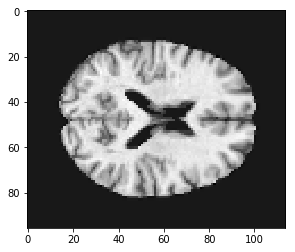

In [39]:
plt.imshow(train_dataset_screening[-1][:,:,48], cmap='gray')
plt.show()

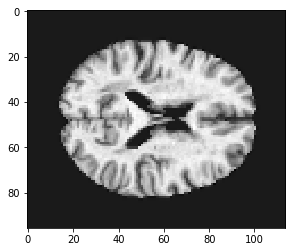

In [40]:
plt.imshow(test_dataset_screening[0][:,:,48], cmap='gray')
plt.show()

In [41]:
!mkdir /analysis/share/ADNI/HDF5_files

mkdir: cannot create directory ‘/analysis/share/ADNI/HDF5_files’: File exists


In [42]:
train_file_paths

['/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Screening/011_S_0003_9-1-05_Screening_32237_Dementia_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month12/011_S_0003_9-12-06_Month12_35576_Dementia_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month24/011_S_0003_9-12-07_Month24_88252_Dementia_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0005/Screening/011_S_0005_9-2-05_Screening_32246_CN_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0005/Month12/011_S_0005_9-5-06_Month12_31906_CN_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0005/Month24/011_S_0005_9-7-07_Month24_200385_CN_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0010/Screening/011_S_0010_11-7-05_Screening_32270_Dementia_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0010/Month12/011_S_0010_

In [43]:
train_file_paths = [item.encode('utf-8') for item in train_file_paths]

In [44]:
h5 = h5py.File('/analysis/share/ADNI/HDF5_files/NO_MCI_train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5', 'w')
h5.create_dataset('X', data=train_dataset)
h5.create_dataset('y', data=train_labels)
h5.create_dataset('files', data=np.array(train_file_paths))
h5.close()

In [45]:
test_file_paths = [item.encode('utf-8') for item in test_file_paths]

In [46]:
h5 = h5py.File('/analysis/share/ADNI/HDF5_files/NO_MCI_test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5', 'w')
h5.create_dataset('X', data=test_dataset)
h5.create_dataset('y', data=test_labels)
h5.create_dataset('files', data=np.array(test_file_paths))
h5.close()

In [47]:
quit()